# 패키지 로드 및 데이터 확인

In [1]:
!pip install -qq transformers

     |████████████████████████████████| 5.8 MB 35.2 MB/s 
     |████████████████████████████████| 7.6 MB 64.1 MB/s 
     |████████████████████████████████| 182 kB 107.0 MB/s 


In [2]:
import transformers
from transformers import (AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup,
                          AutoModelForSequenceClassification,BertPreTrainedModel, BertModel, RobertaModel)


import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Linear, LayerNorm, CrossEntropyLoss
from torch.nn.parameter import Parameter
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/data

Mounted at /content/drive
/content/drive/MyDrive/data


In [4]:
train = pd.read_csv("train.csv")
train.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,neutral
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,neutral
2,TRAIN_0002,That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,neutral
4,TRAIN_0004,My duties? All right.,Chandler,0,surprise


In [5]:
test = pd.read_csv("test.csv")
test.head()

,ID,Utterance,Speaker,Dialogue_ID
0,TEST_0000,Why do all the coffee cups have figures below?,Mark,0
1,TEST_0001,"Oh. It's so Monica can follow. Of this way, if...",Rachell,0
2,TEST_0002,You know what?,Rachell,0
3,TEST_0003,"Come on, Lydia, you can do it.",Joeyy,1
4,TEST_0004,To push!,Joeyy,1


In [6]:
train.shape, test.shape

((9989, 5), (2610, 4))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           9989 non-null   object
 1   Utterance    9989 non-null   object
 2   Speaker      9989 non-null   object
 3   Dialogue_ID  9989 non-null   int64 
 4   Target       9989 non-null   object
dtypes: int64(1), object(4)
memory usage: 390.3+ KB


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


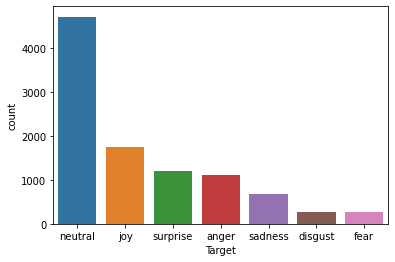

In [8]:
sns.countplot(train.Target, order = train.Target.value_counts().index)

In [9]:
train['Target'] = train['Target'].map({'neutral':0,
                                 'joy':1,
                                 'surprise':2,
                                 'anger':3,
                                 'sadness':4,
                                 'disgust':5,
                                 'fear':6})
train.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,0
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,0
2,TRAIN_0002,That I did. That I did.,Chandler,0,0
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,0
4,TRAIN_0004,My duties? All right.,Chandler,0,2


In [10]:
class_names = train['Target'].unique()
class_names

array([0, 2, 6, 4, 1, 5, 3])

In [11]:
df_test = test
df_test.head()

,ID,Utterance,Speaker,Dialogue_ID
0,TEST_0000,Why do all the coffee cups have figures below?,Mark,0
1,TEST_0001,"Oh. It's so Monica can follow. Of this way, if...",Rachell,0
2,TEST_0002,You know what?,Rachell,0
3,TEST_0003,"Come on, Lydia, you can do it.",Joeyy,1
4,TEST_0004,To push!,Joeyy,1


In [12]:
df_test['Target'] = 0
df_test.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TEST_0000,Why do all the coffee cups have figures below?,Mark,0,0
1,TEST_0001,"Oh. It's so Monica can follow. Of this way, if...",Rachell,0,0
2,TEST_0002,You know what?,Rachell,0,0
3,TEST_0003,"Come on, Lydia, you can do it.",Joeyy,1,0
4,TEST_0004,To push!,Joeyy,1,0


# 전처리

In [13]:
model_name = 'tae898/emoberta-large'

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/408 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

In [15]:
tokenizer.sep_token, tokenizer.sep_token_id

('</s>', 2)

In [16]:
tokenizer.cls_token, tokenizer.cls_token_id

('<s>', 0)

In [17]:
tokenizer.pad_token, tokenizer.pad_token_id

('<pad>', 1)

In [18]:
tokenizer.unk_token, tokenizer.unk_token_id

('<unk>', 3)

In [19]:
tokens_len = []

for txt in train.Utterance :
  tokens = tokenizer.encode(txt, max_length = 128)
  tokens_len.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

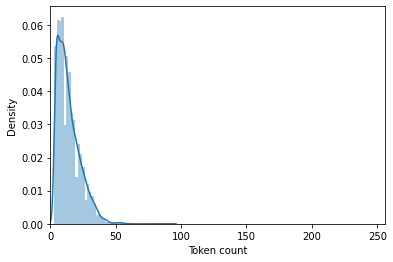

In [20]:
sns.distplot(tokens_len)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [21]:
MAX_LEN = 128

In [22]:
class DialogueDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [23]:
df_train, df_val = train_test_split(train, test_size = 0.1, random_state = RANDOM_SEED)
df_train.shape, df_val.shape

((8990, 5), (999, 5))

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DialogueDataset(
    reviews=df.Utterance.to_numpy(),
    targets=df.Target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
  
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [26]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [27]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModelForSequenceClassification.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    output = self.drop(pooled_output)
    return self.out(output)

In [28]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [42]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape, attention_mask.shape)

torch.Size([16, 128]) torch.Size([16, 128])


In [43]:
F.softmax(model(input_ids, attention_mask), dim=1)

ValueError: ignored

- emoberta-large 모델로 구현하기 위해서는 input 값에 변형을 줘야할 것 같은데, 현재 상황에서는 해당 코드로 더이상 진행 불가